Starting Portfolio Value: 1000.00
Final Portfolio Value: 1000.00


<IPython.core.display.Javascript object>


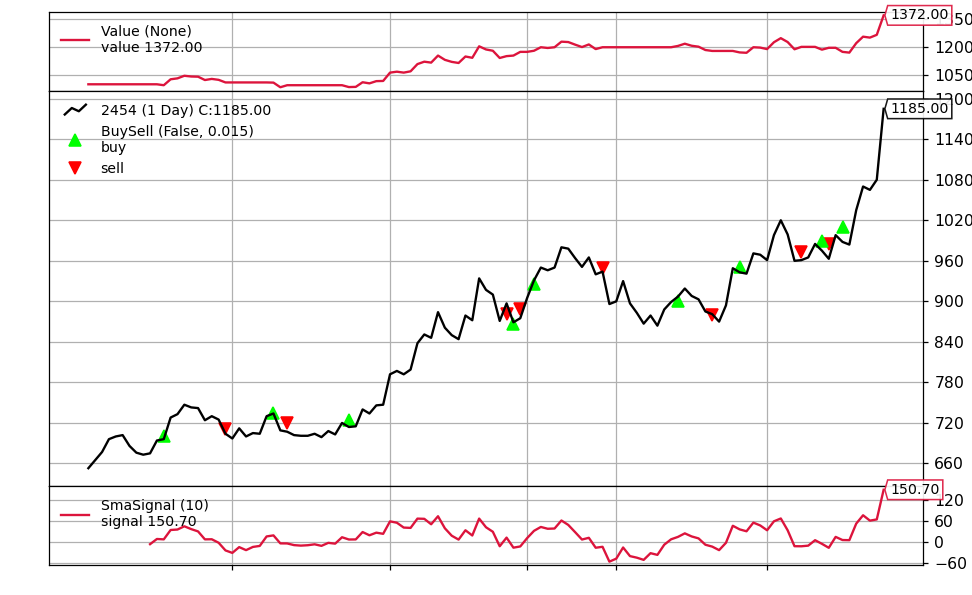

[[<Figure size 800x450 with 3 Axes>]]

In [2]:
#用SMA來回測
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import backtrader as bt
# plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)
#定義 class 表示交易策略
class SmaSignal(bt.Signal):
    params = (('period', 10), )
    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)
#從yahoo Finance下載資料
data = bt.feeds.YahooFinanceData(dataname='2454.TW', 
                                 fromdate=datetime(2020, 11, 1),
                                 todate=datetime(2021, 4, 30))
#設置backtest
cerebro = bt.Cerebro(stdstats = False)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
#執行backtest
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
#繪製圖表
cerebro.plot(iplot=True, volume=False)

In [3]:
#SMA交易策略
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import backtrader as bt
data = bt.feeds.YahooFinanceData(dataname='2454.TW', 
                                 fromdate=datetime(2020, 11, 1),
                                 todate=datetime(2021, 4, 30))
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 10), )

    def __init__(self):
        self.data_close = self.datas[0].close
        self.order = None
        self.price = None
        self.comm = None
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next(self):
        if self.order:
            return
        if not self.position:
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()
cerebro = bt.Cerebro(stdstats = False)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
2020-11-16, BUY CREATED --- Price: 694.00
2020-11-17, BUY EXECUTED --- Price: 701.00, Cost: 701.00, Commission: 0.00
2020-11-27, SELL CREATED --- Price: 725.00
2020-11-30, SELL EXECUTED --- Price: 711.00, Cost: 701.00, Commission: 0.00
2020-11-30, OPERATION RESULT --- Gross: 10.00, Net: 10.00
2020-12-08, BUY CREATED --- Price: 730.00
2020-12-09, BUY EXECUTED --- Price: 735.00, Cost: 735.00, Commission: 0.00
2020-12-10, SELL CREATED --- Price: 709.00
2020-12-11, SELL EXECUTED --- Price: 720.00, Cost: 735.00, Commission: 0.00
2020-12-11, OPERATION RESULT --- Gross: -15.00, Net: -15.00
2020-12-23, BUY CREATED --- Price: 720.00
2020-12-24, BUY EXECUTED --- Price: 724.00, Cost: 724.00, Commission: 0.00
2021-01-26, SELL CREATED --- Price: 871.00
2021-01-27, SELL EXECUTED --- Price: 881.00, Cost: 724.00, Commission: 0.00
2021-01-27, OPERATION RESULT --- Gross: 157.00, Net: 157.00
2021-01-27, BUY CREATED --- Price: 897.00
2021-01-28, BUY EXECUTED --- Price: 86